In [329]:
# IMPORTS
import os
import tensorflow as tf
import time
from collections import deque
from agents.Simulation_DQNW import Simulator

from environment.Config import ConfigTimeSeries
from environment.TimeSeriesModel import TimeSeriesEnvironment
from resources.Utils import load_object, store_object
import numpy as np
import random
from tensorflow import keras


# custom modules
from agents.NeuralNetwork import build_model
from environment import BatchLearning


Trying out different reward functions to fix the 1-step problem appearing on the windowed states


In [330]:
SLIDE_WINDOW_SIZE = 2  # size of the slide window for SLIDE_WINDOW state and reward functions
LAMBDA = 0.9

def SlideWindowStateFuc(timeseries, timeseries_cursor, timeseries_states=None, action=None):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        return [timeseries['value'][i + 1]
                for i in range(timeseries_cursor - SLIDE_WINDOW_SIZE, timeseries_cursor)]
    else:
        return np.zeros(SLIDE_WINDOW_SIZE)


def SlideWindowRewardFuc(timeseries, timeseries_cursor, action):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        sum_anomaly = np.sum(timeseries['anomaly']
                             [timeseries_cursor - SLIDE_WINDOW_SIZE + 1:timeseries_cursor + 1])
        if sum_anomaly == 0:
            if action == 0:
                return 5  # 0.1      # true negative
            else:
                return -5  # 0.5     # false positive, error alarm

        if sum_anomaly > 0:
            if action == 0:
                return -5  # false negative, miss alarm
            else:
                return 5  # 10      # true positive
    else:
        return 0




In [331]:
def build_model():
    model = keras.Sequential()  # linear stack of layers https://keras.io/models/sequential/
    model.add(keras.layers.Dense(SLIDE_WINDOW_SIZE + 1, input_dim=SLIDE_WINDOW_SIZE,
                                 activation='relu'))  # [Input] -> Layer 1
    model.add(keras.layers.Dense(SLIDE_WINDOW_SIZE * 4, activation='relu'))  # Layer 3 -> [output]
    model.add(keras.layers.Dense(SLIDE_WINDOW_SIZE * 4, activation='relu'))  # Layer 3 -> [output]
    model.add(keras.layers.Dense(2, activation='linear'))  # Layer 3 -> [output]
    model.compile(loss='mse',  # Loss function: Mean Squared Error
                  optimizer=keras.optimizers.Adam(
                      lr=0.01))  # Optimaizer: Adam (Feel free to check other options)
    return model

We need to modify our agent to use a multi step target update, so our traces
are able to differentiate between sudden changes in the value function

In [332]:
# Global Variables
BATCH_SIZE = 512


class DDQNWAgent:
    def __init__(self, actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.nA = actions
        self.memory = MemoryBuffer(max=50000)
        self.batch_size = BATCH_SIZE
        self.alpha = alpha
        self.gamma = gamma
        # Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        # fitting param
        self.epoch_count = 10
        self.model = build_model()
        self.model_target = build_model()  # Second (target) neural network
        self.update_target_from_model()  # Update weights
        self.hist = None
        self.loss = []

    def action(self, state):
        # returns a random action or greedy plus a boolean if the action was choosen greedy or random
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA)  # Explore
        if self.epsilon == 0:
            action_vals = self.model_target.predict(np.array(state).reshape(1,
                                                                            SLIDE_WINDOW_SIZE))
            print("Pred 0\n{}".format(action_vals[0][0]))
            print("Pred 1\n{}".format(action_vals[0][1]))
        else:
            action_vals = self.model.predict(np.array(state).reshape(1,
                                                                     SLIDE_WINDOW_SIZE))  # Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals)

    def experience_replay(self, batch_size, lstm, step_size=25):
        # get a sample from the memory buffer
        minibatch = self.memory.get_exp(batch_size)

        # create default input arrays for the fitting of the model
        x = []
        y = []

        st_predict, nst_predict, nst_predict_target = self.predict_on_batch(minibatch)

        index = 0
        step = 1
        reward_ = 0
        for state, action, reward, nstate, done in minibatch:
            if step <= step_size:
                reward_ = reward_ + reward * (LAMBDA**(1/step))
                x.append(state)
                # Predict from state
                nst_action_predict_target = nst_predict_target[index]
                nst_action_predict_model = nst_predict[index]
                if done == True:  # Terminal: Just assign reward
                    target = reward_
                else:  # Non terminal
                    target = reward_ + self.gamma * nst_action_predict_target[
                        np.argmax(nst_action_predict_model)]  # Using Q to get T is Double DQN
                target_f = st_predict[index]
                target_f[action] = target
                y.append(target_f)
                index += 1
                step += 1
            else:
                step = 1
                reward_ = 0
        # Reshape for Keras Fit
        x_reshape = np.array(x)
        y_reshape = np.array(y)
        self.hist = self.model.fit(x_reshape, y_reshape, epochs=self.epoch_count, verbose=0)

    def predict_on_batch(self, batch):
        # Convert to numpy for speed by vectorization
        st = np.array(list(list(zip(*batch))[0]))
        nst = np.array(list(list(zip(*batch))[3]))

        # predict on the batches with the model as well as the target values
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst)

        return st_predict, nst_predict, nst_predict_target

    def update_target_from_model(self):
        # Update the target model from the base model
        self.model_target.set_weights(self.model.get_weights())

    def anneal_eps(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)



We need to modify the Memory Replay, so we can store
every transition inside our environment at least once

In [333]:
class MemoryBuffer:
    def __init__(self, max):
        self.memory = deque([], maxlen=max)
        self.memory_copy = deque([], maxlen=max)

    def store(self, state, action, reward, nstate, done):
        # Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))

    def init_memory(self, env, step_size=25):
        # time measurement for memory initialization
        init_time = time.time()
        # resetting environment once
        env.reset()
        # try to load memory from local file
        if not os.path.isfile("memory.obj"):
            print("Test")
            #self.memory = load_object("memory.obj")
        # try to init memory by taking random steps in our environment until the deque is full
        else:
            # init trajectory step
            step = 1
            reward_ = 0
            action_type = 0
            while True:
                if action_type % 2 == 0:
                    if step <= step_size:
                        # break if memory is full
                        if len(self.memory) >= self.memory.maxlen:
                            break
                        # check if we need to reset env and still fill our memory
                        if env.is_done(env.timeseries_cursor):
                            env.reset()
                            action_type = 1
#                             print("---------NEW STRATEGY INIT-------\n\n\n")
                        # get random action
                        action = 0
                        # take step in env and append
                        state, action, reward, nstate, done = env.step_window(action)
                        reward_ = reward_ + reward * (LAMBDA**(1/step))
                        step += 1
                        # store our memory in class
                        self.store(state, action, reward_, nstate, done)
#                         print("TIMESTAMP: \t{}".format(env.timeseries_cursor))
#                         print(state[-1], action, reward_, nstate[-1], done)
                    else:
#                         print("Starting new trajectory normal")
                        step = 1
                        reward_ = 0
                if action_type % 2 != 0:
                    if step <= step_size:
                        # break if memory is full
                        if len(self.memory) >= self.memory.maxlen:
                            break
                        # check if we need to reset env and still fill our memory
                        if env.is_done(env.timeseries_cursor):
                            env.reset()
                            action_type = 0
#                             print("---------NEW STRATEGY INIT-------\n\n\n")
                        # get random action
                        action = 1
                        # take step in env and append
                        state, action, reward, nstate, done = env.step_window(action)
                        reward_ = reward_ + reward * (LAMBDA**(1/step))
                        step += 1
                        # store our memory in class
                        self.store(state, action, reward_, nstate, done)
#                         print("TIMESTAMP: \t{}".format(env.timeseries_cursor))
#                         print(state[-1], action, reward_, nstate[-1], done)
                    else:
#                         print("Starting new trajectory anomaly")
                        step = 1
                        reward_ = 0
            # store our memory locally to reduce loading time on next run
            store_object(self.memory, "memory.obj")
            print("Memory is full, {} Samples stored. It took {} seconds".format(len(self.memory),
                                                                                 time.time() - init_time))

    def get_exp(self, batch_size):
        # Popping from the Memory Queue which should be filled randomly beforehand
        experience = [self.memory.popleft() for _i in range(batch_size)]
        for exp in experience:
            self.memory_copy.appendleft(exp)
        return experience
        # return random.sample(self.memory, batch_size)

    def get_all_states(self):
        return np.asarray([self.memory.popleft() for _i in range(self.memory.maxlen)])

    def __len__(self):
        return len(self.memory)

In [334]:
# Test the Memory
config = ConfigTimeSeries(seperator=",", window=BatchLearning.SLIDE_WINDOW_SIZE)
env = TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData_1.csv", config=config, window=True)
env.statefunction = SlideWindowStateFuc
env.rewardfunction = SlideWindowRewardFuc
env.timeseries_cursor_init = SLIDE_WINDOW_SIZE
mem = MemoryBuffer(env.timeseries_labeled.shape[0] * 2)
mem.init_memory(env)
# print(len(mem.memory))
# print(mem.get_exp(256))
# print(len(mem.memory))


TimeSeries from: ./Test/SmallData_1.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Header(unlabeled):
    value
0      0
1      0
2      4 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0
Successfully stored to memory.obj
Memory is full, 2848 Samples stored. It took 0.6335799694061279 seconds


The next cell is to test if we have all available actions in our environment taken at least once

TimeSeries from: ./Test/SmallData_1.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Header(unlabeled):
    value
0      0
1      0
2      4 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0
Successfully stored to memory.obj
Memory is full, 50000 Samples stored. It took 8.695602178573608 seconds
Training episode 1 took 162.16146898269653 seconds 
Training episode 2 took 4.46636700630188 seconds 
Training episode 3 took 3.8693346977233887 seconds 
Training episode 4 took 5.588828802108765 seconds 
Training episode 5 took 6.309356212615967 seconds Update Target Model
Training episode 6 took 7.077361106872559 seconds 
Training episode 7 took 7.848104476928711 seconds 
Training episode 8 took 6.6784889698028564 seconds 
Training episode 9 took 8.645739316940308 seconds 
Training episode 10 took 8.590747833251953 seconds Update Target Model
Pred 0
45.02041244506836
Pred 1
4.450664520263672
At Timestamp: 0
State:			[0. 0.]
Action:			0
R

4.826208114624023
At Timestamp: 52
State:			[0.0, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.61799240112305
Pred 1
5.180910110473633
At Timestamp: 53
State:			[0.017699115044247787, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.894710540771484
Pred 1
5.0368194580078125
At Timestamp: 54
State:			[0.015486725663716814, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.81709289550781
Pred 1
5.077236175537109
At Timestamp: 55
State:			[0.011061946902654867, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.61799240112305
Pred 1
5.180910110473633
At Timestamp: 56
State:			[0.017699115044247787, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.35379409790039
Pred 1
5.318477630615234
At Timestamp: 57
State:			[0.015486725663716814, 0.024336283185840708]
Action:			0
Reward:			5
Pred 0
42.787811279296875
Pred 1
5.613187789916992
At Timestamp: 58
State:			[0.024336283185840708, 0.028761061946902654]
Action:			0
Reward:			5
Pred 0
43.045745849609375
Pred 

42.21311950683594
Pred 1
5.912433624267578
At Timestamp: 112
State:			[0.004424778761061947, 0.06415929203539823]
Action:			0
Reward:			5
Pred 0
41.41290283203125
Pred 1
6.329109191894531
At Timestamp: 113
State:			[0.06415929203539823, 0.01991150442477876]
Action:			0
Reward:			5
Pred 0
43.79203414916992
Pred 1
5.09028434753418
At Timestamp: 114
State:			[0.01991150442477876, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.36427688598633
Pred 1
4.792314529418945
At Timestamp: 115
State:			[0.008849557522123894, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.73115921020508
Pred 1
4.601280212402344
At Timestamp: 116
State:			[0.00663716814159292, 0.0]
Action:			0
Reward:			5
Pred 0
44.93025588989258
Pred 1
4.497608184814453
At Timestamp: 117
State:			[0.0, 0.0022123893805309734]
Action:			0
Reward:			5
Pred 0
44.74368667602539
Pred 1
4.594757080078125
At Timestamp: 118
State:			[0.0022123893805309734, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.82757568359375

Pred 1
4.594757080078125
At Timestamp: 176
State:			[0.0022123893805309734, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 177
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 178
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.376808166503906
Pred 1
4.785791397094727
At Timestamp: 179
State:			[0.004424778761061947, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.546630859375
Pred 1
5.218067169189453
At Timestamp: 180
State:			[0.011061946902654867, 0.024336283185840708]
Action:			0
Reward:			5
Pred 0
41.52566146850586
Pred 1
6.270393371582031
At Timestamp: 181
State:			[0.024336283185840708, 0.05973451327433628]
Action:			0
Reward:			5
Pred 0
42.05650329589844
Pred 1
5.993982315063477
At Timestamp: 182
State:			[0.05973451327433628, 0.008849557522123894]
Action:			0
Reward:			5
Pred 

At Timestamp: 235
State:			[0.022123893805309734, 0.01991150442477876]
Action:			0
Reward:			5
Pred 0
43.431419372558594
Pred 1
5.278059005737305
At Timestamp: 236
State:			[0.01991150442477876, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.527835845947266
Pred 1
5.227853775024414
At Timestamp: 237
State:			[0.017699115044247787, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.527835845947266
Pred 1
5.227853775024414
At Timestamp: 238
State:			[0.017699115044247787, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.347530364990234
Pred 1
5.321739196777344
At Timestamp: 239
State:			[0.017699115044247787, 0.022123893805309734]
Action:			0
Reward:			5
Pred 0
43.334999084472656
Pred 1
5.328264236450195
At Timestamp: 240
State:			[0.022123893805309734, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.347530364990234
Pred 1
5.321739196777344
At Timestamp: 241
State:			[0.017699115044247787, 0.022123893805309734]
Action:			0
Reward:			5
Pred 0
43.51530838012695

Pred 1
5.133966445922852
At Timestamp: 293
State:			[0.017699115044247787, 0.01327433628318584]
Action:			0
Reward:			5
Pred 0
43.90098190307617
Pred 1
5.03355598449707
At Timestamp: 294
State:			[0.01327433628318584, 0.01327433628318584]
Action:			0
Reward:			5
Pred 0
43.99113464355469
Pred 1
4.986612319946289
At Timestamp: 295
State:			[0.01327433628318584, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.81709289550781
Pred 1
5.077236175537109
At Timestamp: 296
State:			[0.011061946902654867, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.79829788208008
Pred 1
5.08702278137207
At Timestamp: 297
State:			[0.017699115044247787, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.90724563598633
Pred 1
5.030292510986328
At Timestamp: 298
State:			[0.011061946902654867, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.263641357421875
Pred 1
5.365419387817383
At Timestamp: 299
State:			[0.015486725663716814, 0.02654867256637168]
Action:			0
Reward:			5
Pred 0
43

6.861797332763672
At Timestamp: 351
State:			[0.0752212389380531, 0.0331858407079646]
Action:			0
Reward:			5
Pred 0
42.49229431152344
Pred 1
5.767065048217773
At Timestamp: 352
State:			[0.0331858407079646, 0.02654867256637168]
Action:			0
Reward:			5
Pred 0
42.60124206542969
Pred 1
5.710334777832031
At Timestamp: 353
State:			[0.02654867256637168, 0.030973451327433628]
Action:			0
Reward:			5
Pred 0
42.588714599609375
Pred 1
5.716859817504883
At Timestamp: 354
State:			[0.030973451327433628, 0.02654867256637168]
Action:			0
Reward:			5
Pred 0
42.51108932495117
Pred 1
5.7572784423828125
At Timestamp: 355
State:			[0.02654867256637168, 0.0331858407079646]
Action:			0
Reward:			5
Pred 0
42.49229431152344
Pred 1
5.767065048217773
At Timestamp: 356
State:			[0.0331858407079646, 0.02654867256637168]
Action:			0
Reward:			5
Pred 0
42.51108932495117
Pred 1
5.7572784423828125
At Timestamp: 357
State:			[0.02654867256637168, 0.0331858407079646]
Action:			0
Reward:			5
Pred 0
42.762752532958984

Pred 1
6.549501419067383
At Timestamp: 410
State:			[0.08628318584070796, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.370540618896484
Pred 1
4.789052963256836
At Timestamp: 411
State:			[0.00663716814159292, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.45443344116211
Pred 1
4.745370864868164
At Timestamp: 412
State:			[0.008849557522123894, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 413
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 414
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.5571174621582
Pred 1
4.691904067993164
At Timestamp: 415
State:			[0.004424778761061947, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.10007858276367
Pred 1
4.92988395690918
At Timestamp: 416
State:			[0.00663716814159292, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43

43.90098190307617
Pred 1
5.03355598449707
At Timestamp: 470
State:			[0.01327433628318584, 0.01327433628318584]
Action:			0
Reward:			5
Pred 0
44.0812873840332
Pred 1
4.939668655395508
At Timestamp: 471
State:			[0.01327433628318584, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.45443344116211
Pred 1
4.745370864868164
At Timestamp: 472
State:			[0.008849557522123894, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 473
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 474
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 475
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 476
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Re

33.092342376708984
Pred 1
10.661659240722656
At Timestamp: 529
State:			[0.13716814159292035, 0.14601769911504425]
Action:			0
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 530
State:			[0.14601769911504425, 0.21902654867256638]
Action:			1
Reward:			-5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 531
State:			[0.21902654867256638, 0.17256637168141592]
Action:			1
Reward:			-5
Pred 0
34.07395935058594
Pred 1
10.150529861450195
At Timestamp: 532
State:			[0.17256637168141592, 0.08407079646017698]
Action:			0
Reward:			5
Pred 0
39.73375701904297
Pred 1
7.203447341918945
At Timestamp: 533
State:			[0.08407079646017698, 0.03982300884955752]
Action:			0
Reward:			5
Pred 0
41.84242630004883
Pred 1
6.10545539855957
At Timestamp: 534
State:			[0.03982300884955752, 0.035398230088495575]
Action:			0
Reward:			5
Pred 0
41.945106506347656
Pred 1
6.0519866943359375
At Timestamp: 535
State:			[0.035398230088495575, 0.03761061946902655]
Action:			0

Pred 0
34.314456939697266
Pred 1
10.025299072265625
At Timestamp: 591
State:			[0.11946902654867256, 0.13495575221238937]
Action:			0
Reward:			5
Pred 0
33.72968292236328
Pred 1
10.329793930053711
At Timestamp: 592
State:			[0.13495575221238937, 0.1327433628318584]
Action:			0
Reward:			5
Pred 0
35.53902053833008
Pred 1
9.387664794921875
At Timestamp: 593
State:			[0.1327433628318584, 0.09070796460176991]
Action:			0
Reward:			5
Pred 0
37.37096405029297
Pred 1
8.433761596679688
At Timestamp: 594
State:			[0.09070796460176991, 0.09070796460176991]
Action:			0
Reward:			5
Pred 0
37.37096405029297
Pred 1
8.433761596679688
At Timestamp: 595
State:			[0.09070796460176991, 0.09070796460176991]
Action:			0
Reward:			5
Pred 0
37.28081512451172
Pred 1
8.480705261230469
At Timestamp: 596
State:			[0.09070796460176991, 0.09292035398230089]
Action:			0
Reward:			5
Pred 0
37.635162353515625
Pred 1
8.296194076538086
At Timestamp: 597
State:			[0.09292035398230089, 0.08185840707964602]
Action:			0
Re

Pred 1
5.660131454467773
At Timestamp: 651
State:			[0.024336283185840708, 0.030973451327433628]
Action:			0
Reward:			5
Pred 0
42.498558044433594
Pred 1
5.763803482055664
At Timestamp: 652
State:			[0.030973451327433628, 0.028761061946902654]
Action:			0
Reward:			5
Pred 0
42.50482940673828
Pred 1
5.760538101196289
At Timestamp: 653
State:			[0.028761061946902654, 0.030973451327433628]
Action:			0
Reward:			5
Pred 0
43.03948211669922
Pred 1
5.482141494750977
At Timestamp: 654
State:			[0.030973451327433628, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.71440887451172
Pred 1
5.130704879760742
At Timestamp: 655
State:			[0.015486725663716814, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.98487091064453
Pred 1
4.989873886108398
At Timestamp: 656
State:			[0.015486725663716814, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
42.47105407714844
Pred 1
5.778125762939453
At Timestamp: 657
State:			[0.008849557522123894, 0.05309734513274336]
Action:			0
Reward:			5
Pre

State:			[0.011061946902654867, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.82757568359375
Pred 1
4.55107307434082
At Timestamp: 715
State:			[0.004424778761061947, 0.0]
Action:			0
Reward:			5
Pred 0
44.84010696411133
Pred 1
4.544549942016602
At Timestamp: 716
State:			[0.0, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.82757568359375
Pred 1
4.55107307434082
At Timestamp: 717
State:			[0.004424778761061947, 0.0]
Action:			0
Reward:			5
Pred 0
44.659793853759766
Pred 1
4.638437271118164
At Timestamp: 718
State:			[0.0, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.003662109375
Pred 1
4.98008918762207
At Timestamp: 719
State:			[0.008849557522123894, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.6242561340332
Pred 1
5.177646636962891
At Timestamp: 720
State:			[0.015486725663716814, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
44.24906539916992
Pred 1
4.852304458618164
At Timestamp: 721
State:			[0.017699115044247787, 0.0]
Action:			0
Re

At Timestamp: 777
State:			[0.4269911504424779, 0.5464601769911505]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 778
State:			[0.5464601769911505, 0.3561946902654867]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 779
State:			[0.3561946902654867, 0.37610619469026546]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 780
State:			[0.37610619469026546, 0.413716814159292]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 781
State:			[0.413716814159292, 0.3915929203539823]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 782
State:			[0.3915929203539823, 0.38495575221238937]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 783
State:			[0.38495575221238937, 0.5331858407079646]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291

Pred 1
34.57291030883789
At Timestamp: 838
State:			[0.20353982300884954, 0.2079646017699115]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 839
State:			[0.2079646017699115, 0.16150442477876106]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 840
State:			[0.16150442477876106, 0.19911504424778761]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 841
State:			[0.19911504424778761, 0.18141592920353983]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 842
State:			[0.18141592920353983, 0.2920353982300885]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 843
State:			[0.2920353982300885, 0.3473451327433628]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 844
State:			[0.3473451327433628, 0.5420353982300885]
Action:			1
Reward:			5
Pred 0
-13.5

43.77950668334961
Pred 1
5.096809387207031
At Timestamp: 897
State:			[0.024336283185840708, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.01618957519531
Pred 1
4.973564147949219
At Timestamp: 898
State:			[0.004424778761061947, 0.01991150442477876]
Action:			0
Reward:			5
Pred 0
43.97233581542969
Pred 1
4.99639892578125
At Timestamp: 899
State:			[0.01991150442477876, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
43.38511657714844
Pred 1
5.302167892456055
At Timestamp: 900
State:			[0.004424778761061947, 0.035398230088495575]
Action:			0
Reward:			5
Pred 0
43.117103576660156
Pred 1
5.441722869873047
At Timestamp: 901
State:			[0.035398230088495575, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
43.372589111328125
Pred 1
5.308691024780273
At Timestamp: 902
State:			[0.008849557522123894, 0.030973451327433628]
Action:			0
Reward:			5
Pred 0
42.94932556152344
Pred 1
5.529087066650391
At Timestamp: 903
State:			[0.030973451327433628, 0.017699115044247787]
Action:			

State:			[0.0, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
43.739463806152344
Pred 1
5.117658615112305
At Timestamp: 959
State:			[0.00663716814159292, 0.024336283185840708]
Action:			0
Reward:			5
Pred 0
40.533973693847656
Pred 1
6.786771774291992
At Timestamp: 960
State:			[0.024336283185840708, 0.08407079646017698]
Action:			0
Reward:			5
Pred 0
38.38145446777344
Pred 1
7.907596588134766
At Timestamp: 961
State:			[0.08407079646017698, 0.07300884955752213]
Action:			0
Reward:			5
Pred 0
41.658302307128906
Pred 1
6.201328277587891
At Timestamp: 962
State:			[0.07300884955752213, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.5571174621582
Pred 1
4.691904067993164
At Timestamp: 963
State:			[0.004424778761061947, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.460693359375
Pred 1
4.7421112060546875
At Timestamp: 964
State:			[0.00663716814159292, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.19023513793945
Pred 1
4.882940292358398
At Timestamp: 965
Sta

34.57291030883789
At Timestamp: 1022
State:			[0.9070796460176991, 0.6504424778761062]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1023
State:			[0.6504424778761062, 0.7809734513274336]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1024
State:			[0.7809734513274336, 0.7699115044247787]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1025
State:			[0.7699115044247787, 0.5508849557522124]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1026
State:			[0.5508849557522124, 0.4225663716814159]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1027
State:			[0.4225663716814159, 0.4800884955752212]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1028
State:			[0.4800884955752212, 0.43805309734513276]
Action:			1
Reward:			5
Pred 0
-13.5966444

42.88423538208008
Pred 1
5.562980651855469
At Timestamp: 1087
State:			[0.022123893805309734, 0.028761061946902654]
Action:			0
Reward:			5
Pred 0
42.4146728515625
Pred 1
5.807483673095703
At Timestamp: 1088
State:			[0.028761061946902654, 0.0331858407079646]
Action:			0
Reward:			5
Pred 0
42.40214157104492
Pred 1
5.814008712768555
At Timestamp: 1089
State:			[0.0331858407079646, 0.028761061946902654]
Action:			0
Reward:			5
Pred 0
41.873748779296875
Pred 1
6.089145660400391
At Timestamp: 1090
State:			[0.028761061946902654, 0.046460176991150445]
Action:			0
Reward:			5
Pred 0
41.19255447387695
Pred 1
6.443843841552734
At Timestamp: 1091
State:			[0.046460176991150445, 0.04424778761061947]
Action:			0
Reward:			5
Pred 0
41.018516540527344
Pred 1
6.534467697143555
At Timestamp: 1092
State:			[0.04424778761061947, 0.050884955752212385]
Action:			0
Reward:			5
Pred 0
41.811100006103516
Pred 1
6.12176513671875
At Timestamp: 1093
State:			[0.050884955752212385, 0.024336283185840708]
Action:

At Timestamp: 1148
State:			[0.00663716814159292, 0.0]
Action:			0
Reward:			5
Pred 0
44.84010696411133
Pred 1
4.544549942016602
At Timestamp: 1149
State:			[0.0, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.82757568359375
Pred 1
4.55107307434082
At Timestamp: 1150
State:			[0.004424778761061947, 0.0]
Action:			0
Reward:			5
Pred 0
44.659793853759766
Pred 1
4.638437271118164
At Timestamp: 1151
State:			[0.0, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.634735107421875
Pred 1
4.651485443115234
At Timestamp: 1152
State:			[0.008849557522123894, 0.0]
Action:			0
Reward:			5
Pred 0
44.74995422363281
Pred 1
4.59149169921875
At Timestamp: 1153
State:			[0.0, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.55084991455078
Pred 1
4.695167541503906
At Timestamp: 1154
State:			[0.00663716814159292, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
43.835880279541016
Pred 1
5.067451477050781
At Timestamp: 1155
State:			[0.004424778761061947, 0.024336283185840708]
Ac

43.720672607421875
Pred 1
5.127443313598633
At Timestamp: 1212
State:			[0.01327433628318584, 0.017699115044247787]
Action:			0
Reward:			5
Pred 0
43.70814514160156
Pred 1
5.133966445922852
At Timestamp: 1213
State:			[0.017699115044247787, 0.01327433628318584]
Action:			0
Reward:			5
Pred 0
44.0812873840332
Pred 1
4.939668655395508
At Timestamp: 1214
State:			[0.01327433628318584, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.27412414550781
Pred 1
4.839258193969727
At Timestamp: 1215
State:			[0.008849557522123894, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.45443344116211
Pred 1
4.745370864868164
At Timestamp: 1216
State:			[0.008849557522123894, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.64726638793945
Pred 1
4.644960403442383
At Timestamp: 1217
State:			[0.004424778761061947, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.82757568359375
Pred 1
4.55107307434082
At Timestamp: 1218
State:			[0.004424778761061947, 0.0]
Action:			0
Reward:			5

Pred 0
43.70814514160156
Pred 1
5.133966445922852
At Timestamp: 1278
State:			[0.017699115044247787, 0.01327433628318584]
Action:			0
Reward:			5
Pred 0
43.810821533203125
Pred 1
5.080499649047852
At Timestamp: 1279
State:			[0.01327433628318584, 0.015486725663716814]
Action:			0
Reward:			5
Pred 0
43.894710540771484
Pred 1
5.0368194580078125
At Timestamp: 1280
State:			[0.015486725663716814, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.3663215637207
Pred 1
5.311956405639648
At Timestamp: 1281
State:			[0.011061946902654867, 0.028761061946902654]
Action:			0
Reward:			5
Pred 0
43.76697540283203
Pred 1
5.10333251953125
At Timestamp: 1282
State:			[0.028761061946902654, 0.0]
Action:			0
Reward:			5
Pred 0
44.56964111328125
Pred 1
4.685380935668945
At Timestamp: 1283
State:			[0.0, 0.011061946902654867]
Action:			0
Reward:			5
Pred 0
43.636783599853516
Pred 1
5.171123504638672
At Timestamp: 1284
State:			[0.011061946902654867, 0.022123893805309734]
Action:			0
Reward:			5
Pred 

Reward:			5
Pred 0
44.46696090698242
Pred 1
4.7388458251953125
At Timestamp: 1336
State:			[0.004424778761061947, 0.008849557522123894]
Action:			0
Reward:			5
Pred 0
44.36427688598633
Pred 1
4.792314529418945
At Timestamp: 1337
State:			[0.008849557522123894, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.73115921020508
Pred 1
4.601280212402344
At Timestamp: 1338
State:			[0.00663716814159292, 0.0]
Action:			0
Reward:			5
Pred 0
45.02041244506836
Pred 1
4.450664520263672
At Timestamp: 1339
State:			[0.0, 0.0]
Action:			0
Reward:			5
Pred 0
44.93025588989258
Pred 1
4.497608184814453
At Timestamp: 1340
State:			[0.0, 0.0022123893805309734]
Action:			0
Reward:			5
Pred 0
44.65353012084961
Pred 1
4.641698837280273
At Timestamp: 1341
State:			[0.0022123893805309734, 0.00663716814159292]
Action:			0
Reward:			5
Pred 0
44.55084991455078
Pred 1
4.695167541503906
At Timestamp: 1342
State:			[0.00663716814159292, 0.004424778761061947]
Action:			0
Reward:			5
Pred 0
44.73741912841797
Pre

Pred 1
34.57291030883789
At Timestamp: 1397
State:			[0.24778761061946902, 0.27876106194690264]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1398
State:			[0.27876106194690264, 0.2942477876106195]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1399
State:			[0.2942477876106195, 0.2721238938053097]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1400
State:			[0.2721238938053097, 0.28982300884955753]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1401
State:			[0.28982300884955753, 0.32964601769911506]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1402
State:			[0.32964601769911506, 0.5685840707964601]
Action:			1
Reward:			5
Pred 0
-13.596644401550293
Pred 1
34.57291030883789
At Timestamp: 1403
State:			[0.5685840707964601, 0.46238938053097345]
Action:			1
Reward:			5
Pred

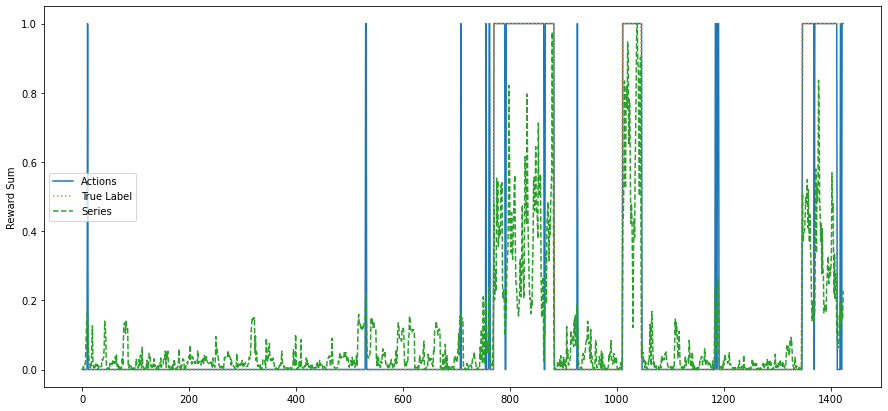

True

In [335]:
tf.compat.v1.disable_eager_execution()

# Create the agent
config = ConfigTimeSeries(seperator=",", window=BatchLearning.SLIDE_WINDOW_SIZE)
env = TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData_1.csv", config=config, window=True)
env.statefunction = SlideWindowStateFuc
env.rewardfunction = SlideWindowRewardFuc

memory = MemoryBuffer(50000)

dqn = DDQNWAgent(env.action_space_n, 0.001, 0.9, 1, 0, 0.9)
dqn.memory = memory
dqn.memory.init_memory(env)
simulation = Simulator(11, dqn, env, 5)
simulation.run()